# 1. Preprocessing and feature extraction

(20000, 28, 28)
(5000, 28, 28)


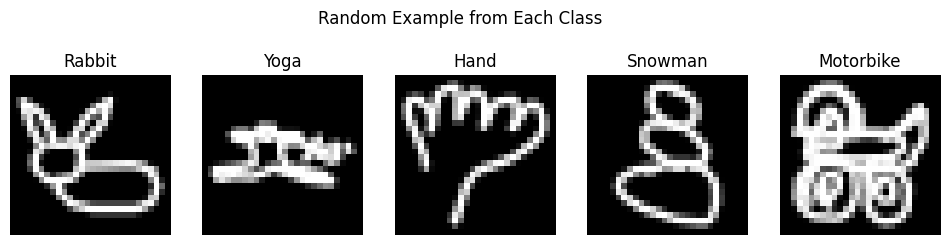

Training Set Class Counts:
Rabbit    : 4000
Yoga      : 4000
Hand      : 4000
Snowman   : 4000
Motorbike : 4000

Test Set Class Counts:
Rabbit    : 1000
Yoga      : 1000
Hand      : 1000
Snowman   : 1000
Motorbike : 1000
(20000, 588)
(5000, 588)


In [1]:
import numpy as np
from skimage.feature import hog
from skimage.filters import sobel
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from cvxopt import matrix, solvers
from sklearn.model_selection import KFold
import time
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC


train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

print(train_images.shape) # (20000, 28, 28)
print(test_images.shape) # (5000, 28, 28)

## Labels

## The integer labels correspond to the following classes:
## - 0: rabbit
## - 1: yoga
## - 2: hand
## - 3: snowman
## - 4: motorbike

class_names = ['Rabbit', 'Yoga', 'Hand', 'Snowman', 'Motorbike']

plt.figure(figsize=(12, 3))
for class_id in range(5):
    indices = np.where(train_labels == class_id)[0]
    random_idx = np.random.choice(indices)
    plt.subplot(1, 5, class_id + 1)
    plt.imshow(train_images[random_idx], cmap='gray')
    plt.title(f"{class_names[class_id]}")
    plt.axis('off')
plt.suptitle("Random Example from Each Class")
plt.show()

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

print("Training Set Class Counts:")
for i in range(5):
    print(f"{class_names[i]:<10}: {train_counts[i]}")

print("\nTest Set Class Counts:")
for i in range(5):
    print(f"{class_names[i]:<10}: {test_counts[i]}")

def extract_features(images):
    features = []
    for img in images:
        # hog features
        hog_features = hog(img, orientations=12, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=False, feature_vector=True)
        features.append(hog_features)

    return np.array(features)

train_features = extract_features(train_images)
test_features = extract_features(test_images)

print(train_features.shape)
print(test_features.shape)

# Part 1. Soft Margin SVM from Scratch

In [2]:
solvers.options['show_progress'] = False

def linear_svm_train(X, y, C=1.0):
    n_samples, n_features = X.shape
    K = np.dot(X, X.T)
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G_std = np.diag(-np.ones(n_samples))
    h_std = np.zeros(n_samples)
    G_slack = np.diag(np.ones(n_samples))
    h_slack = np.ones(n_samples) * C
    G = matrix(np.vstack((G_std, G_slack)))
    h = matrix(np.hstack((h_std, h_slack)))
    A = matrix(y.astype(float), (1, n_samples))
    b = matrix(0.0)

    solution = solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(solution['x'])

    sv = alpha > 1e-5
    alpha_sv = alpha[sv]
    support_vectors = X[sv]
    support_labels = y[sv]

    w = np.sum(alpha_sv[:, None] * support_labels[:, None] * support_vectors, axis=0)
    b = np.mean(support_labels - np.dot(support_vectors, w))
    return w, b, alpha

def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)

def get_binary_data(X, y, class1, class2):
    idx = np.where((y == class1) | (y == class2))[0]
    X_bin = X[idx]
    y_bin = y[idx]
    y_bin = np.where(y_bin == class1, -1, 1)
    return X_bin, y_bin

def cross_validate(X, y, C_values, k=5):
    print("Starting cross-validation...")
    best_C = None
    best_score = -np.inf
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for C in C_values:
        scores = []
        print(f"\nC = {C}")
        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            fold_start = time.time()
            w, b, _ = linear_svm_train(X_train, y_train, C)
            fold_time = time.time() - fold_start
            preds = predict(X_val, w, b)
            acc = np.mean(preds == y_val)
            scores.append(acc)
            print(f"  Fold {fold}: Accuracy = {acc:.4f}, Time = {fold_time:.2f} sec")
        avg_acc = np.mean(scores)
        print(f"  Avg Accuracy for C={C}: {avg_acc:.4f}")
        if avg_acc > best_score:
            best_score = avg_acc
            best_C = C

    print(f"\nBest C selected: {best_C} with CV Accuracy = {best_score:.4f}")
    return best_C

def fast_cross_validate(X, y, C_values, k=5):
    best_C = None
    best_score = -np.inf
    for C in C_values:
        clf = SVC(C=C, kernel='linear')
        scores = cross_val_score(clf, X, y, cv=k)
        mean_score = scores.mean()
        print(f"C = {C} | Mean CV Accuracy: {mean_score:.4f}")
        if mean_score > best_score:
            best_score = mean_score
            best_C = C
    print(f"\nBest C selected (via fast CV): {best_C}")
    return best_C

In [3]:
# Prepare binary dataset (class 0 vs 1)
X_bin, y_bin = get_binary_data(train_features, train_labels, 0, 2)
X_test_bin, y_test_bin = get_binary_data(test_features, test_labels, 0, 2)

# Grid of C values
C_values = [0.001, 0.01, 0.1, 1]

# Cross-validation
overall_start = time.time()
best_C = fast_cross_validate(X_bin, y_bin, C_values)

# Final training
print("\nTraining final model...")
train_start = time.time()
w, b, _ = linear_svm_train(X_bin, y_bin, best_C)
train_time = time.time() - train_start
print(f"Final training completed in {train_time:.2f} seconds.")

# Evaluation
y_pred = predict(X_test_bin, w, b)
test_accuracy = np.mean(y_pred == y_test_bin)

overall_time = time.time() - overall_start
print("\n=== Final Results ===")
print(f"Test Accuracy:       {test_accuracy * 100:.2f}%")
print(f"Training Time:       {train_time:.2f} seconds")
print(f"Total Run Time:      {overall_time:.2f} seconds")

C = 0.001 | Mean CV Accuracy: 0.9307
C = 0.01 | Mean CV Accuracy: 0.9415
C = 0.1 | Mean CV Accuracy: 0.9364
C = 1 | Mean CV Accuracy: 0.9224

Best C selected (via fast CV): 0.01

Training final model...
Final training completed in 696.05 seconds.

=== Final Results ===
Test Accuracy:       94.25%
Training Time:       696.05 seconds
Total Run Time:      861.75 seconds


# Part 2. Soft Margin SVM from sklearn

### 2.1. Linear Kernel

In [4]:
start = time.time()

linear_params = {'C': [0.001, 0.01, 0.1, 1]}
linear_clf = GridSearchCV(LinearSVC(max_iter=10000), linear_params, cv=5)
linear_clf.fit(X_bin, y_bin)

linear_time = time.time() - start
linear_pred = linear_clf.predict(X_test_bin)
linear_acc = accuracy_score(y_test_bin, linear_pred)

print("LinearSVC:")
print(f"  Best C: {linear_clf.best_params_['C']}")
print(f"  Test Accuracy: {linear_acc * 100:.2f}%")
print(f"  Training Time: {linear_time:.2f} seconds")

LinearSVC:
  Best C: 0.01
  Test Accuracy: 94.25%
  Training Time: 6.05 seconds


### 2.2. RBF Kernel

In [5]:
start = time.time()

rbf_params = {'C': [0.01, 0.1, 1], 'gamma': ['scale', 0.01, 0.001]}
rbf_clf = GridSearchCV(SVC(kernel='rbf'), rbf_params, cv=5)
rbf_clf.fit(X_bin, y_bin)

rbf_time = time.time() - start
rbf_pred = rbf_clf.predict(X_test_bin)
rbf_acc = accuracy_score(y_test_bin, rbf_pred)

print("\nSVC with RBF Kernel:")
print(f"  Best Params: {rbf_clf.best_params_}")
print(f"  Test Accuracy: {rbf_acc * 100:.2f}%")
print(f"  Training Time: {rbf_time:.2f} seconds")


SVC with RBF Kernel:
  Best Params: {'C': 1, 'gamma': 'scale'}
  Test Accuracy: 95.55%
  Training Time: 958.39 seconds


### 2.3. Polynomial Kernel

In [6]:
start = time.time()

poly_params = {'C': [0.01, 0.1, 1], 'degree': [2, 3], 'coef0': [0, 1]}
poly_clf = GridSearchCV(SVC(kernel='poly'), poly_params, cv=5)
poly_clf.fit(X_bin, y_bin)

poly_time = time.time() - start
poly_pred = poly_clf.predict(X_test_bin)
poly_acc = accuracy_score(y_test_bin, poly_pred)

print("\nSVC with Polynomial Kernel:")
print(f"  Best Params: {poly_clf.best_params_}")
print(f"  Test Accuracy: {poly_acc * 100:.2f}%")
print(f"  Training Time: {poly_time:.2f} seconds")


SVC with Polynomial Kernel:
  Best Params: {'C': 1, 'coef0': 0, 'degree': 3}
  Test Accuracy: 95.70%
  Training Time: 698.09 seconds


# Part 3. Results

In [7]:
# Best model
best_clf = SVC(kernel='poly', C=1, degree=3, coef0=0)
best_clf.fit(X_bin, y_bin)

SVC(C=1, coef0=0, kernel='poly')

### Example Support Vectors

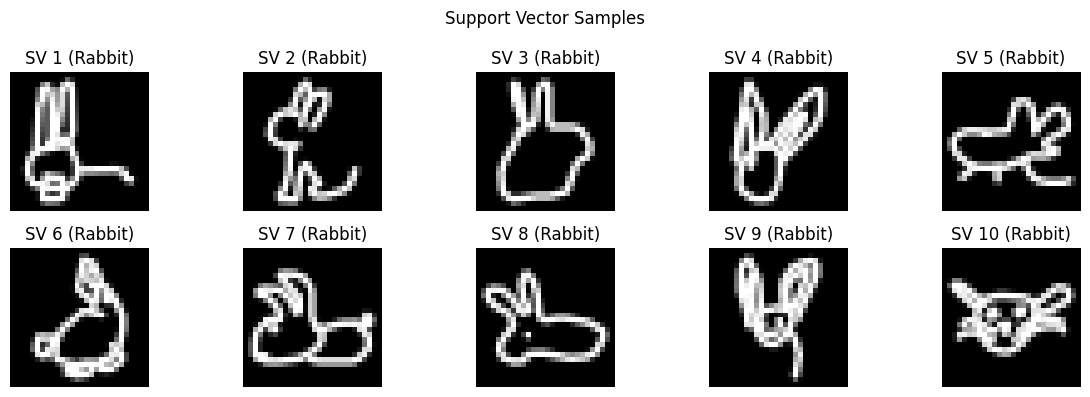

In [10]:
# Indices of support vectors
support_indices = best_clf.support_

X_bin_orig = train_images[(train_labels == 0) | (train_labels == 2)]
y_bin_orig = train_labels[(train_labels == 0) | (train_labels == 2)]
y_bin_orig = np.where(y_bin_orig == 0, 1, -1)

support_vector_images = X_bin_orig[support_indices]
support_vector_labels = y_bin_orig[support_indices]

class_name_map = {1: "Rabbit", -1: "Hand"}
plt.figure(figsize=(12, 4))
for i in range(10):  # Show first 10 support vectors
    label = class_name_map[support_vector_labels[i]]
    plt.subplot(2, 5, i + 1)
    plt.imshow(support_vector_images[i], cmap='gray')
    plt.title(f"SV {i+1} ({label})")
    plt.axis('off')
plt.suptitle("Support Vector Samples")
plt.tight_layout()
plt.show()

### Example Non-Support Vectors

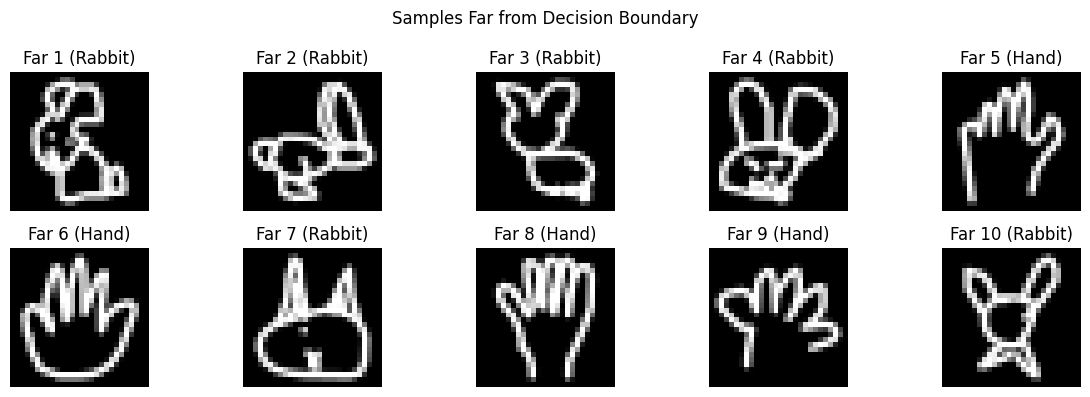

In [11]:
train_images_bin = train_images[(train_labels == 0) | (train_labels == 2)]
train_labels_bin = train_labels[(train_labels == 0) | (train_labels == 2)]
y_bin = np.where(train_labels_bin == 0, 1, -1)

non_sv_indices = list(set(range(len(train_images_bin))) - set(support_indices))
far_samples = np.random.choice(non_sv_indices, 10, replace=False)

plt.figure(figsize=(12, 4))
for i, idx in enumerate(far_samples):
    label = class_name_map[y_bin[idx]]
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images_bin[idx], cmap='gray')
    plt.title(f"Far {i+1} ({label})")
    plt.axis('off')
plt.suptitle("Samples Far from Decision Boundary")
plt.tight_layout()
plt.show()
